In [31]:
import tensorflow as tf
import os
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import gc
import seaborn as sns
import re
from sklearn.preprocessing import LabelEncoder,MinMaxScaler
from sklearn.impute import SimpleImputer
from tensorflow.keras import optimizers
from tensorflow.keras import layers,Model

In [32]:
# import data
trainData = pd.read_csv('train.csv',header = 0)
testData = pd.read_csv('test.csv',header = 0)
pId = testData['PassengerId']

In [41]:
# Add title
def NameToTitle(name):
    title = re.search(", ([A-Za-z]+)\. ",name)
    if title:
        return title.group(1)
    else:
        return "A"


trainData["Title"] = trainData['Name'].apply(NameToTitle)
trainData.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Title
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S,Mr
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C,Mrs
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S,Miss
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S,Mrs
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S,Mr


In [3]:
# Deal with missing values
def nan_padding(data, columns):
    for column in columns:
        imputer=SimpleImputer()
        data[column]=imputer.fit_transform(data[column].values.reshape(-1,1))
    return data

columns = ["SibSp", "Parch","Fare"]

trainData = nan_padding(trainData, columns)
testData = nan_padding(testData, columns)

trainData.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1.0,0.0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1.0,0.0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0.0,0.0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1.0,0.0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0.0,0.0,373450,8.0500,NaN,S


In [4]:
def DummyData(data, columns):
    for c in columns:
        data = pd.concat([data,pd.get_dummies(data[c],prefix = c)],axis = 1)
        data = data.drop(c,axis = 1)
    return data

columns = ['Pclass','Embarked']
trainData = DummyData(trainData,columns)
testData = DummyData(testData,columns)

trainData.head()

,PassengerId,Survived,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Pclass_1,Pclass_2,Pclass_3,Embarked_C,Embarked_Q,Embarked_S
0,1,0,"Braund, Mr. Owen Harris",male,22.0,1.0,0.0,A/5 21171,7.2500,NaN,0,0,1,0,0,1
1,2,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1.0,0.0,PC 17599,71.2833,C85,1,0,0,1,0,0
2,3,1,"Heikkinen, Miss. Laina",female,26.0,0.0,0.0,STON/O2. 3101282,7.9250,NaN,0,0,1,0,0,1
3,4,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1.0,0.0,113803,53.1000,C123,1,0,0,0,0,1
4,5,0,"Allen, Mr. William Henry",male,35.0,0.0,0.0,373450,8.0500,NaN,0,0,1,0,0,1


In [5]:
def ConvertSex(data):
    le = LabelEncoder()
    le.fit(['male','female'])
    data['Sex'] = le.transform(data['Sex'])
    return
ConvertSex(trainData)
ConvertSex(testData)

trainData.head()

,PassengerId,Survived,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Pclass_1,Pclass_2,Pclass_3,Embarked_C,Embarked_Q,Embarked_S
0,1,0,"Braund, Mr. Owen Harris",1,22.0,1.0,0.0,A/5 21171,7.2500,NaN,0,0,1,0,0,1
1,2,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",0,38.0,1.0,0.0,PC 17599,71.2833,C85,1,0,0,1,0,0
2,3,1,"Heikkinen, Miss. Laina",0,26.0,0.0,0.0,STON/O2. 3101282,7.9250,NaN,0,0,1,0,0,1
3,4,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",0,35.0,1.0,0.0,113803,53.1000,C123,1,0,0,0,0,1
4,5,0,"Allen, Mr. William Henry",1,35.0,0.0,0.0,373450,8.0500,NaN,0,0,1,0,0,1


In [6]:
# Has Cabin
trainData['HasCabin'] = trainData['Cabin'].apply(lambda x:0 if type(x) == float else 1)
testData['HasCabin'] = testData['Cabin'].apply(lambda x:0 if type(x) == float else 1)

trainData.head()
testData.head()

,PassengerId,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Pclass_1,Pclass_2,Pclass_3,Embarked_C,Embarked_Q,Embarked_S,HasCabin
0,892,"Kelly, Mr. James",1,34.5,0.0,0.0,330911,7.8292,NaN,0,0,1,0,1,0,0
1,893,"Wilkes, Mrs. James (Ellen Needs)",0,47.0,1.0,0.0,363272,7.0000,NaN,0,0,1,0,0,1,0
2,894,"Myles, Mr. Thomas Francis",1,62.0,0.0,0.0,240276,9.6875,NaN,0,1,0,0,1,0,0
3,895,"Wirz, Mr. Albert",1,27.0,0.0,0.0,315154,8.6625,NaN,0,0,1,0,0,1,0
4,896,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",0,22.0,1.0,1.0,3101298,12.2875,NaN,0,0,1,0,0,1,0


In [7]:
# Family size
trainData['FamilySize'] = trainData['SibSp'] + trainData['Parch'] + 1
testData['FamilySize'] = testData['SibSp'] + testData['Parch'] + 1

trainData['IsAlone'] = trainData['FamilySize'].apply(lambda x: 1 if x==1 else 0)
testData['IsAlone'] = testData['FamilySize'].apply(lambda x: 1 if x==1 else 0)


trainData.head()

,PassengerId,Survived,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Pclass_1,Pclass_2,Pclass_3,Embarked_C,Embarked_Q,Embarked_S,HasCabin,FamilySize,IsAlone
0,1,0,"Braund, Mr. Owen Harris",1,22.0,1.0,0.0,A/5 21171,7.2500,NaN,0,0,1,0,0,1,0,2.0,0
1,2,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",0,38.0,1.0,0.0,PC 17599,71.2833,C85,1,0,0,1,0,0,1,2.0,0
2,3,1,"Heikkinen, Miss. Laina",0,26.0,0.0,0.0,STON/O2. 3101282,7.9250,NaN,0,0,1,0,0,1,0,1.0,1
3,4,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",0,35.0,1.0,0.0,113803,53.1000,C123,1,0,0,0,0,1,1,2.0,0
4,5,0,"Allen, Mr. William Henry",1,35.0,0.0,0.0,373450,8.0500,NaN,0,0,1,0,0,1,0,1.0,1


In [8]:
# Change age
def ConvertAge(age):
    if age <=12 :
        return 0        
    elif age<=18:
        return 1
    elif age<=60:
        return 2
    else : return 3
trainData['AgeRange'] = trainData['Age'].apply(ConvertAge)
testData['AgeRange'] = testData['Age'].apply(ConvertAge)
trainData.head()

,PassengerId,Survived,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Pclass_1,Pclass_2,Pclass_3,Embarked_C,Embarked_Q,Embarked_S,HasCabin,FamilySize,IsAlone,AgeRange
0,1,0,"Braund, Mr. Owen Harris",1,22.0,1.0,0.0,A/5 21171,7.2500,NaN,0,0,1,0,0,1,0,2.0,0,2
1,2,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",0,38.0,1.0,0.0,PC 17599,71.2833,C85,1,0,0,1,0,0,1,2.0,0,2
2,3,1,"Heikkinen, Miss. Laina",0,26.0,0.0,0.0,STON/O2. 3101282,7.9250,NaN,0,0,1,0,0,1,0,1.0,1,2
3,4,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",0,35.0,1.0,0.0,113803,53.1000,C123,1,0,0,0,0,1,1,2.0,0,2
4,5,0,"Allen, Mr. William Henry",1,35.0,0.0,0.0,373450,8.0500,NaN,0,0,1,0,0,1,0,1.0,1,2


,PassengerId,Survived,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,...,Pclass_2,Pclass_3,Embarked_C,Embarked_Q,Embarked_S,HasCabin,FamilySize,IsAlone,AgeRange,FareRange
0,1,0,"Braund, Mr. Owen Harris",1,22.0,1.0,0.0,A/5 21171,7.2500,NaN,...,0,1,0,0,1,0,2.0,0,2,0
1,2,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",0,38.0,1.0,0.0,PC 17599,71.2833,C85,...,0,0,1,0,0,1,2.0,0,2,4
2,3,1,"Heikkinen, Miss. Laina",0,26.0,0.0,0.0,STON/O2. 3101282,7.9250,NaN,...,0,1,0,0,1,0,1.0,1,2,0
3,4,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",0,35.0,1.0,0.0,113803,53.1000,C123,...,0,0,0,0,1,1,2.0,0,2,4
4,5,0,"Allen, Mr. William Henry",1,35.0,0.0,0.0,373450,8.0500,NaN,...,0,1,0,0,1,0,1.0,1,2,1


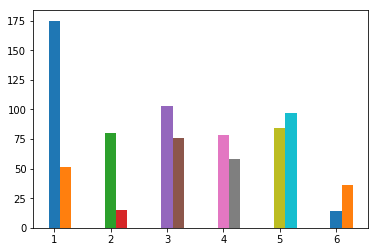

In [9]:
j = 0
k = 0
for i in [8,10,20,30,100,300]:
    k+=1
    plt.bar(k,((trainData['Fare']<i) & (trainData['Fare']>j) & (trainData['Survived']==0)).sum(),0.2)
    plt.bar(k+0.2,((trainData['Fare']<i) & (trainData['Fare']>j) & (trainData['Survived']==1)).sum(),0.2)
    j = i

# Change fare
def ConvertFare(fare):
    if fare <=8 :
        return 0    
    elif fare<=10:
        return 1
    elif fare<=20:
        return 2
    elif fare<=30:
        return 3
    elif fare<=100:
        return 4
    elif fare<=300:
        return 5
    else : return 6
trainData['FareRange'] = trainData['Fare'].apply(ConvertFare)
testData['FareRange'] = testData['Fare'].apply(ConvertFare)
trainData.head()

In [10]:
def NormalizeData(data,columns):
    scaler = MinMaxScaler()
    for c in columns:
        data[c] = scaler.fit_transform(data[c].values.reshape(-1,1))
    return data


columns = ['Fare']
#trainData = NormalizeData(trainData,columns)
#testData = NormalizeData(testData,columns)

#trainData.head()

In [11]:
# Drop useless data
def DropColumn(data, columns):    
    return data.drop(columns,axis = 1)


columns = ['PassengerId','Name',"Ticket", "Cabin","Age","Fare","SibSp","Parch"]
trainData = DropColumn(trainData,columns)
testData = DropColumn(testData,columns)

trainData.head()

,Survived,Sex,Pclass_1,Pclass_2,Pclass_3,Embarked_C,Embarked_Q,Embarked_S,HasCabin,FamilySize,IsAlone,AgeRange,FareRange
0,0,1,0,0,1,0,0,1,0,2.0,0,2,0
1,1,0,1,0,0,1,0,0,1,2.0,0,2,4
2,1,0,0,0,1,0,0,1,0,1.0,1,2,0
3,1,0,1,0,0,0,0,1,1,2.0,0,2,4
4,0,1,0,0,1,0,0,1,0,1.0,1,2,1


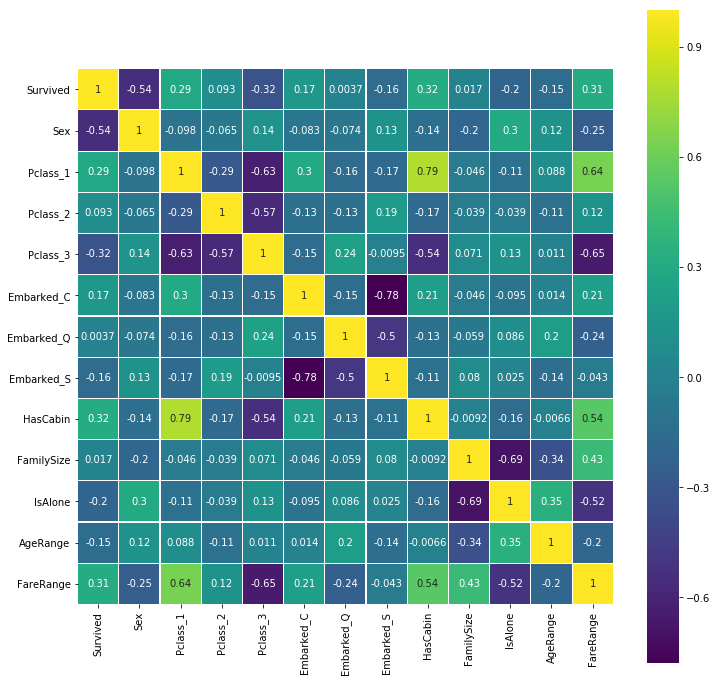

In [12]:
# Visualize co-relation
colormap = plt.cm.viridis
plt.figure(figsize=(12,12))
#plt.title("Correlation of Features")
sns.heatmap(trainData.astype(float).corr(),linewidths=0.1,vmax=1.0,square = True, cmap=colormap,linecolor='white',annot=True)

In [13]:
# train data after processing
trainData.head()


,Survived,Sex,Pclass_1,Pclass_2,Pclass_3,Embarked_C,Embarked_Q,Embarked_S,HasCabin,FamilySize,IsAlone,AgeRange,FareRange
0,0,1,0,0,1,0,0,1,0,2.0,0,2,0
1,1,0,1,0,0,1,0,0,1,2.0,0,2,4
2,1,0,0,0,1,0,0,1,0,1.0,1,2,0
3,1,0,1,0,0,0,0,1,1,2.0,0,2,4
4,0,1,0,0,1,0,0,1,0,1.0,1,2,1


In [14]:
# test data after processing
testData.head()

,Sex,Pclass_1,Pclass_2,Pclass_3,Embarked_C,Embarked_Q,Embarked_S,HasCabin,FamilySize,IsAlone,AgeRange,FareRange
0,1,0,0,1,0,1,0,0,1.0,1,2,0
1,0,0,0,1,0,0,1,0,2.0,0,2,0
2,1,0,1,0,0,1,0,0,1.0,1,3,1
3,1,0,0,1,0,0,1,0,1.0,1,2,1
4,0,0,0,1,0,0,1,0,3.0,0,2,2


In [15]:
trainX = trainData.iloc[:,1:].to_numpy()
trainY = trainData.loc[:,'Survived'].to_numpy()
testX = testData.iloc[:,:].to_numpy()
testY = pd.read_csv('gender_submission.csv',header = 0).iloc[:,1].to_numpy()

In [16]:
# Check point
cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath = "./checkpoint.ckpt" , 
                                                 save_weights_only = True,
                                                 save_best_only = True,
                                                 peroid=5, 
                                                 verbose = 1)

In [17]:
def CreateModel():
    model = tf.keras.Sequential([
        tf.keras.layers.Dense(units = 512, 
                              activation = 'relu', 
                              input_shape=(trainX.shape[1],), 
                              kernel_regularizer = tf.keras.regularizers.l1(0.001)),                               
        tf.keras.layers.Dense(units = 512, activation = 'relu', kernel_regularizer = tf.keras.regularizers.l1(0.001)),        
        tf.keras.layers.Dropout(0.3), 
        tf.keras.layers.Dense(units = 512, activation = 'relu', kernel_regularizer = tf.keras.regularizers.l1(0.001)), 
        tf.keras.layers.Dropout(0.3), 
        tf.keras.layers.Dense(units = 512, activation = 'relu', kernel_regularizer = tf.keras.regularizers.l1(0.001)),                
        tf.keras.layers.Dropout(0.3), 
        tf.keras.layers.Dense(1,activation='sigmoid')
    ])
    return model

In [18]:
model = CreateModel()
model.compile(loss = 'binary_crossentropy',
             optimizer=tf.keras.optimizers.Adam(lr = 0.0001),
             metrics = ['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 512)               6656      
_________________________________________________________________
dense_1 (Dense)              (None, 512)               262656    
_________________________________________________________________
dropout (Dropout)            (None, 512)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 512)               262656    
_________________________________________________________________
dropout_1 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 512)               262656    
_________________________________________________________________
dropout_2 (Dropout)          (None, 512)               0

In [19]:
#model.load_weights('./checkpoint.ckpt')
history = model.fit(  x = trainX,
                      y = trainY,
                      epochs = 2000,
                      verbose = 2,
                      validation_data = (testX,testY),
                      callbacks=[cp_callback],
                     )
          

Train on 891 samples, validate on 418 samples
Epoch 1/2000

Epoch 00001: val_loss improved from inf to 29.13420, saving model to ./checkpoint.ckpt
891/891 - 2s - loss: 30.1637 - accuracy: 0.6128 - val_loss: 29.1342 - val_accuracy: 0.6364
Epoch 2/2000

Epoch 00002: val_loss improved from 29.13420 to 27.24519, saving model to ./checkpoint.ckpt
891/891 - 1s - loss: 28.2321 - accuracy: 0.6352 - val_loss: 27.2452 - val_accuracy: 0.7129
Epoch 3/2000

Epoch 00003: val_loss improved from 27.24519 to 25.42071, saving model to ./checkpoint.ckpt
891/891 - 1s - loss: 26.3639 - accuracy: 0.6857 - val_loss: 25.4207 - val_accuracy: 0.7177
Epoch 4/2000

Epoch 00004: val_loss improved from 25.42071 to 23.66530, saving model to ./checkpoint.ckpt
891/891 - 1s - loss: 24.5785 - accuracy: 0.7104 - val_loss: 23.6653 - val_accuracy: 0.7153
Epoch 5/2000

Epoch 00005: val_loss improved from 23.66530 to 21.98884, saving model to ./checkpoint.ckpt
891/891 - 1s - loss: 22.8526 - accuracy: 0.7205 - val_loss: 21.98

Epoch 43/2000

Epoch 00043: val_loss improved from 0.88449 to 0.86390, saving model to ./checkpoint.ckpt
891/891 - 1s - loss: 0.9749 - accuracy: 0.8013 - val_loss: 0.8639 - val_accuracy: 0.8780
Epoch 44/2000

Epoch 00044: val_loss improved from 0.86390 to 0.84266, saving model to ./checkpoint.ckpt
891/891 - 1s - loss: 0.9553 - accuracy: 0.8002 - val_loss: 0.8427 - val_accuracy: 0.8923
Epoch 45/2000

Epoch 00045: val_loss improved from 0.84266 to 0.82788, saving model to ./checkpoint.ckpt
891/891 - 1s - loss: 0.9471 - accuracy: 0.7901 - val_loss: 0.8279 - val_accuracy: 0.8780
Epoch 46/2000

Epoch 00046: val_loss improved from 0.82788 to 0.80845, saving model to ./checkpoint.ckpt
891/891 - 1s - loss: 0.9295 - accuracy: 0.7890 - val_loss: 0.8084 - val_accuracy: 0.8852
Epoch 47/2000

Epoch 00047: val_loss improved from 0.80845 to 0.79338, saving model to ./checkpoint.ckpt
891/891 - 1s - loss: 0.8947 - accuracy: 0.8025 - val_loss: 0.7934 - val_accuracy: 0.8780
Epoch 48/2000

Epoch 00048: va


Epoch 00086: val_loss improved from 0.54095 to 0.53638, saving model to ./checkpoint.ckpt
891/891 - 1s - loss: 0.6768 - accuracy: 0.8013 - val_loss: 0.5364 - val_accuracy: 0.9306
Epoch 87/2000

Epoch 00087: val_loss did not improve from 0.53638
891/891 - 0s - loss: 0.6758 - accuracy: 0.7980 - val_loss: 0.5366 - val_accuracy: 0.9306
Epoch 88/2000

Epoch 00088: val_loss improved from 0.53638 to 0.52950, saving model to ./checkpoint.ckpt
891/891 - 1s - loss: 0.6649 - accuracy: 0.8002 - val_loss: 0.5295 - val_accuracy: 0.9258
Epoch 89/2000

Epoch 00089: val_loss improved from 0.52950 to 0.52539, saving model to ./checkpoint.ckpt
891/891 - 1s - loss: 0.6664 - accuracy: 0.8002 - val_loss: 0.5254 - val_accuracy: 0.9354
Epoch 90/2000

Epoch 00090: val_loss improved from 0.52539 to 0.52383, saving model to ./checkpoint.ckpt
891/891 - 1s - loss: 0.6658 - accuracy: 0.8002 - val_loss: 0.5238 - val_accuracy: 0.9354
Epoch 91/2000

Epoch 00091: val_loss improved from 0.52383 to 0.52250, saving model

891/891 - 1s - loss: 0.6064 - accuracy: 0.7969 - val_loss: 0.4638 - val_accuracy: 0.9450
Epoch 132/2000

Epoch 00132: val_loss did not improve from 0.46379
891/891 - 0s - loss: 0.6131 - accuracy: 0.8013 - val_loss: 0.4666 - val_accuracy: 0.9402
Epoch 133/2000

Epoch 00133: val_loss improved from 0.46379 to 0.46190, saving model to ./checkpoint.ckpt
891/891 - 1s - loss: 0.6182 - accuracy: 0.7957 - val_loss: 0.4619 - val_accuracy: 0.9378
Epoch 134/2000

Epoch 00134: val_loss did not improve from 0.46190
891/891 - 0s - loss: 0.6221 - accuracy: 0.8114 - val_loss: 0.4624 - val_accuracy: 0.9330
Epoch 135/2000

Epoch 00135: val_loss did not improve from 0.46190
891/891 - 0s - loss: 0.6147 - accuracy: 0.7969 - val_loss: 0.4634 - val_accuracy: 0.9378
Epoch 136/2000

Epoch 00136: val_loss did not improve from 0.46190
891/891 - 0s - loss: 0.6268 - accuracy: 0.7980 - val_loss: 0.4654 - val_accuracy: 0.9378
Epoch 137/2000

Epoch 00137: val_loss did not improve from 0.46190
891/891 - 0s - loss: 0.60

Epoch 180/2000

Epoch 00180: val_loss did not improve from 0.43273
891/891 - 0s - loss: 0.5907 - accuracy: 0.8070 - val_loss: 0.4384 - val_accuracy: 0.9258
Epoch 181/2000

Epoch 00181: val_loss did not improve from 0.43273
891/891 - 0s - loss: 0.5813 - accuracy: 0.8070 - val_loss: 0.4372 - val_accuracy: 0.9282
Epoch 182/2000

Epoch 00182: val_loss improved from 0.43273 to 0.43147, saving model to ./checkpoint.ckpt
891/891 - 1s - loss: 0.5744 - accuracy: 0.8103 - val_loss: 0.4315 - val_accuracy: 0.9330
Epoch 183/2000

Epoch 00183: val_loss did not improve from 0.43147
891/891 - 0s - loss: 0.5963 - accuracy: 0.8081 - val_loss: 0.4365 - val_accuracy: 0.9330
Epoch 184/2000

Epoch 00184: val_loss did not improve from 0.43147
891/891 - 0s - loss: 0.5908 - accuracy: 0.8137 - val_loss: 0.4376 - val_accuracy: 0.9282
Epoch 185/2000

Epoch 00185: val_loss did not improve from 0.43147
891/891 - 0s - loss: 0.5898 - accuracy: 0.8103 - val_loss: 0.4352 - val_accuracy: 0.9258
Epoch 186/2000

Epoch 001


Epoch 00230: val_loss did not improve from 0.41512
891/891 - 0s - loss: 0.5673 - accuracy: 0.8047 - val_loss: 0.4184 - val_accuracy: 0.9211
Epoch 231/2000

Epoch 00231: val_loss did not improve from 0.41512
891/891 - 0s - loss: 0.5763 - accuracy: 0.8081 - val_loss: 0.4161 - val_accuracy: 0.9211
Epoch 232/2000

Epoch 00232: val_loss did not improve from 0.41512
891/891 - 0s - loss: 0.5649 - accuracy: 0.8070 - val_loss: 0.4164 - val_accuracy: 0.9211
Epoch 233/2000

Epoch 00233: val_loss did not improve from 0.41512
891/891 - 0s - loss: 0.5774 - accuracy: 0.8159 - val_loss: 0.4180 - val_accuracy: 0.9211
Epoch 234/2000

Epoch 00234: val_loss did not improve from 0.41512
891/891 - 0s - loss: 0.5765 - accuracy: 0.8114 - val_loss: 0.4185 - val_accuracy: 0.9211
Epoch 235/2000

Epoch 00235: val_loss did not improve from 0.41512
891/891 - 0s - loss: 0.5656 - accuracy: 0.8159 - val_loss: 0.4166 - val_accuracy: 0.9211
Epoch 236/2000

Epoch 00236: val_loss did not improve from 0.41512
891/891 - 0s

Epoch 280/2000

Epoch 00280: val_loss did not improve from 0.40356
891/891 - 0s - loss: 0.5569 - accuracy: 0.8148 - val_loss: 0.4045 - val_accuracy: 0.9211
Epoch 281/2000

Epoch 00281: val_loss did not improve from 0.40356
891/891 - 0s - loss: 0.5538 - accuracy: 0.8137 - val_loss: 0.4045 - val_accuracy: 0.9187
Epoch 282/2000

Epoch 00282: val_loss did not improve from 0.40356
891/891 - 0s - loss: 0.5623 - accuracy: 0.8070 - val_loss: 0.4056 - val_accuracy: 0.9187
Epoch 283/2000

Epoch 00283: val_loss did not improve from 0.40356
891/891 - 0s - loss: 0.5548 - accuracy: 0.8272 - val_loss: 0.4067 - val_accuracy: 0.9187
Epoch 284/2000

Epoch 00284: val_loss did not improve from 0.40356
891/891 - 0s - loss: 0.5604 - accuracy: 0.8215 - val_loss: 0.4065 - val_accuracy: 0.9211
Epoch 285/2000

Epoch 00285: val_loss did not improve from 0.40356
891/891 - 0s - loss: 0.5559 - accuracy: 0.8227 - val_loss: 0.4065 - val_accuracy: 0.9187
Epoch 286/2000

Epoch 00286: val_loss did not improve from 0.403


Epoch 00330: val_loss did not improve from 0.39833
891/891 - 0s - loss: 0.5442 - accuracy: 0.8103 - val_loss: 0.3996 - val_accuracy: 0.9067
Epoch 331/2000

Epoch 00331: val_loss did not improve from 0.39833
891/891 - 0s - loss: 0.5445 - accuracy: 0.8182 - val_loss: 0.4002 - val_accuracy: 0.9115
Epoch 332/2000

Epoch 00332: val_loss did not improve from 0.39833
891/891 - 0s - loss: 0.5482 - accuracy: 0.8013 - val_loss: 0.4019 - val_accuracy: 0.9019
Epoch 333/2000

Epoch 00333: val_loss improved from 0.39833 to 0.39663, saving model to ./checkpoint.ckpt
891/891 - 1s - loss: 0.5412 - accuracy: 0.8126 - val_loss: 0.3966 - val_accuracy: 0.9067
Epoch 334/2000

Epoch 00334: val_loss improved from 0.39663 to 0.39564, saving model to ./checkpoint.ckpt
891/891 - 1s - loss: 0.5446 - accuracy: 0.8260 - val_loss: 0.3956 - val_accuracy: 0.9115
Epoch 335/2000

Epoch 00335: val_loss did not improve from 0.39564
891/891 - 0s - loss: 0.5516 - accuracy: 0.8126 - val_loss: 0.3982 - val_accuracy: 0.9139
E

Epoch 380/2000

Epoch 00380: val_loss did not improve from 0.38800
891/891 - 0s - loss: 0.5432 - accuracy: 0.8070 - val_loss: 0.3923 - val_accuracy: 0.8900
Epoch 381/2000

Epoch 00381: val_loss did not improve from 0.38800
891/891 - 0s - loss: 0.5366 - accuracy: 0.8215 - val_loss: 0.3906 - val_accuracy: 0.9115
Epoch 382/2000

Epoch 00382: val_loss did not improve from 0.38800
891/891 - 0s - loss: 0.5289 - accuracy: 0.8249 - val_loss: 0.3893 - val_accuracy: 0.8900
Epoch 383/2000

Epoch 00383: val_loss improved from 0.38800 to 0.38725, saving model to ./checkpoint.ckpt
891/891 - 1s - loss: 0.5231 - accuracy: 0.8305 - val_loss: 0.3872 - val_accuracy: 0.8900
Epoch 384/2000

Epoch 00384: val_loss improved from 0.38725 to 0.38546, saving model to ./checkpoint.ckpt
891/891 - 1s - loss: 0.5298 - accuracy: 0.8193 - val_loss: 0.3855 - val_accuracy: 0.8995
Epoch 385/2000

Epoch 00385: val_loss did not improve from 0.38546
891/891 - 0s - loss: 0.5265 - accuracy: 0.8238 - val_loss: 0.3875 - val_acc

Epoch 432/2000

Epoch 00432: val_loss did not improve from 0.38485
891/891 - 0s - loss: 0.5265 - accuracy: 0.8159 - val_loss: 0.3851 - val_accuracy: 0.8900
Epoch 433/2000

Epoch 00433: val_loss did not improve from 0.38485
891/891 - 0s - loss: 0.5333 - accuracy: 0.8182 - val_loss: 0.3862 - val_accuracy: 0.8900
Epoch 434/2000

Epoch 00434: val_loss did not improve from 0.38485
891/891 - 0s - loss: 0.5333 - accuracy: 0.8283 - val_loss: 0.3888 - val_accuracy: 0.8947
Epoch 435/2000

Epoch 00435: val_loss did not improve from 0.38485
891/891 - 0s - loss: 0.5329 - accuracy: 0.8148 - val_loss: 0.3865 - val_accuracy: 0.8900
Epoch 436/2000

Epoch 00436: val_loss did not improve from 0.38485
891/891 - 0s - loss: 0.5224 - accuracy: 0.8171 - val_loss: 0.3874 - val_accuracy: 0.8995
Epoch 437/2000

Epoch 00437: val_loss did not improve from 0.38485
891/891 - 0s - loss: 0.5254 - accuracy: 0.8215 - val_loss: 0.3852 - val_accuracy: 0.8900
Epoch 438/2000

Epoch 00438: val_loss did not improve from 0.384

Epoch 483/2000

Epoch 00483: val_loss did not improve from 0.37954
891/891 - 0s - loss: 0.5188 - accuracy: 0.8193 - val_loss: 0.3821 - val_accuracy: 0.8852
Epoch 484/2000

Epoch 00484: val_loss did not improve from 0.37954
891/891 - 0s - loss: 0.5314 - accuracy: 0.8249 - val_loss: 0.3819 - val_accuracy: 0.8995
Epoch 485/2000

Epoch 00485: val_loss did not improve from 0.37954
891/891 - 0s - loss: 0.5332 - accuracy: 0.8159 - val_loss: 0.3837 - val_accuracy: 0.8995
Epoch 486/2000

Epoch 00486: val_loss did not improve from 0.37954
891/891 - 0s - loss: 0.5083 - accuracy: 0.8272 - val_loss: 0.3835 - val_accuracy: 0.8971
Epoch 487/2000

Epoch 00487: val_loss did not improve from 0.37954
891/891 - 0s - loss: 0.5119 - accuracy: 0.8305 - val_loss: 0.3821 - val_accuracy: 0.8804
Epoch 488/2000

Epoch 00488: val_loss did not improve from 0.37954
891/891 - 0s - loss: 0.5179 - accuracy: 0.8249 - val_loss: 0.3803 - val_accuracy: 0.8995
Epoch 489/2000

Epoch 00489: val_loss improved from 0.37954 to 0


Epoch 00535: val_loss improved from 0.37799 to 0.37772, saving model to ./checkpoint.ckpt
891/891 - 1s - loss: 0.5046 - accuracy: 0.8159 - val_loss: 0.3777 - val_accuracy: 0.8995
Epoch 536/2000

Epoch 00536: val_loss improved from 0.37772 to 0.37696, saving model to ./checkpoint.ckpt
891/891 - 1s - loss: 0.5119 - accuracy: 0.8305 - val_loss: 0.3770 - val_accuracy: 0.8995
Epoch 537/2000

Epoch 00537: val_loss did not improve from 0.37696
891/891 - 0s - loss: 0.5177 - accuracy: 0.8283 - val_loss: 0.3786 - val_accuracy: 0.8995
Epoch 538/2000

Epoch 00538: val_loss did not improve from 0.37696
891/891 - 0s - loss: 0.5129 - accuracy: 0.8227 - val_loss: 0.3782 - val_accuracy: 0.8876
Epoch 539/2000

Epoch 00539: val_loss did not improve from 0.37696
891/891 - 0s - loss: 0.5210 - accuracy: 0.8260 - val_loss: 0.3798 - val_accuracy: 0.8804
Epoch 540/2000

Epoch 00540: val_loss did not improve from 0.37696
891/891 - 0s - loss: 0.5199 - accuracy: 0.8283 - val_loss: 0.3784 - val_accuracy: 0.8995
E

Epoch 586/2000

Epoch 00586: val_loss did not improve from 0.37344
891/891 - 0s - loss: 0.5133 - accuracy: 0.8227 - val_loss: 0.3775 - val_accuracy: 0.8852
Epoch 587/2000

Epoch 00587: val_loss did not improve from 0.37344
891/891 - 0s - loss: 0.5242 - accuracy: 0.8227 - val_loss: 0.3759 - val_accuracy: 0.8900
Epoch 588/2000

Epoch 00588: val_loss did not improve from 0.37344
891/891 - 0s - loss: 0.5227 - accuracy: 0.8227 - val_loss: 0.3774 - val_accuracy: 0.8923
Epoch 589/2000

Epoch 00589: val_loss did not improve from 0.37344
891/891 - 0s - loss: 0.5295 - accuracy: 0.8193 - val_loss: 0.3786 - val_accuracy: 0.8804
Epoch 590/2000

Epoch 00590: val_loss did not improve from 0.37344
891/891 - 0s - loss: 0.5095 - accuracy: 0.8204 - val_loss: 0.3784 - val_accuracy: 0.8971
Epoch 591/2000

Epoch 00591: val_loss did not improve from 0.37344
891/891 - 0s - loss: 0.5193 - accuracy: 0.8294 - val_loss: 0.3753 - val_accuracy: 0.8804
Epoch 592/2000

Epoch 00592: val_loss did not improve from 0.373


Epoch 00638: val_loss did not improve from 0.37094
891/891 - 0s - loss: 0.5117 - accuracy: 0.8159 - val_loss: 0.3759 - val_accuracy: 0.8780
Epoch 639/2000

Epoch 00639: val_loss did not improve from 0.37094
891/891 - 0s - loss: 0.5166 - accuracy: 0.8260 - val_loss: 0.3764 - val_accuracy: 0.8995
Epoch 640/2000

Epoch 00640: val_loss did not improve from 0.37094
891/891 - 0s - loss: 0.5138 - accuracy: 0.8182 - val_loss: 0.3778 - val_accuracy: 0.8995
Epoch 641/2000

Epoch 00641: val_loss did not improve from 0.37094
891/891 - 0s - loss: 0.5047 - accuracy: 0.8316 - val_loss: 0.3752 - val_accuracy: 0.8780
Epoch 642/2000

Epoch 00642: val_loss did not improve from 0.37094
891/891 - 0s - loss: 0.5156 - accuracy: 0.8283 - val_loss: 0.3720 - val_accuracy: 0.8876
Epoch 643/2000

Epoch 00643: val_loss did not improve from 0.37094
891/891 - 0s - loss: 0.5166 - accuracy: 0.8193 - val_loss: 0.3754 - val_accuracy: 0.8995
Epoch 644/2000

Epoch 00644: val_loss did not improve from 0.37094
891/891 - 0s

Epoch 691/2000

Epoch 00691: val_loss did not improve from 0.36920
891/891 - 0s - loss: 0.5064 - accuracy: 0.8193 - val_loss: 0.3735 - val_accuracy: 0.8876
Epoch 692/2000

Epoch 00692: val_loss did not improve from 0.36920
891/891 - 0s - loss: 0.5081 - accuracy: 0.8171 - val_loss: 0.3708 - val_accuracy: 0.8900
Epoch 693/2000

Epoch 00693: val_loss did not improve from 0.36920
891/891 - 0s - loss: 0.5162 - accuracy: 0.8350 - val_loss: 0.3731 - val_accuracy: 0.8852
Epoch 694/2000

Epoch 00694: val_loss did not improve from 0.36920
891/891 - 0s - loss: 0.5057 - accuracy: 0.8294 - val_loss: 0.3719 - val_accuracy: 0.8780
Epoch 695/2000

Epoch 00695: val_loss did not improve from 0.36920
891/891 - 0s - loss: 0.5184 - accuracy: 0.8272 - val_loss: 0.3722 - val_accuracy: 0.8876
Epoch 696/2000

Epoch 00696: val_loss did not improve from 0.36920
891/891 - 0s - loss: 0.5103 - accuracy: 0.8238 - val_loss: 0.3721 - val_accuracy: 0.8852
Epoch 697/2000

Epoch 00697: val_loss did not improve from 0.369

Epoch 744/2000

Epoch 00744: val_loss did not improve from 0.36843
891/891 - 0s - loss: 0.5143 - accuracy: 0.8294 - val_loss: 0.3710 - val_accuracy: 0.8732
Epoch 745/2000

Epoch 00745: val_loss did not improve from 0.36843
891/891 - 0s - loss: 0.5091 - accuracy: 0.8260 - val_loss: 0.3724 - val_accuracy: 0.8780
Epoch 746/2000

Epoch 00746: val_loss did not improve from 0.36843
891/891 - 0s - loss: 0.5042 - accuracy: 0.8339 - val_loss: 0.3758 - val_accuracy: 0.8804
Epoch 747/2000

Epoch 00747: val_loss did not improve from 0.36843
891/891 - 0s - loss: 0.5069 - accuracy: 0.8215 - val_loss: 0.3714 - val_accuracy: 0.8828
Epoch 748/2000

Epoch 00748: val_loss did not improve from 0.36843
891/891 - 0s - loss: 0.5128 - accuracy: 0.8283 - val_loss: 0.3705 - val_accuracy: 0.8947
Epoch 749/2000

Epoch 00749: val_loss did not improve from 0.36843
891/891 - 0s - loss: 0.5074 - accuracy: 0.8260 - val_loss: 0.3722 - val_accuracy: 0.8732
Epoch 750/2000

Epoch 00750: val_loss did not improve from 0.368


Epoch 00796: val_loss did not improve from 0.36528
891/891 - 0s - loss: 0.4968 - accuracy: 0.8406 - val_loss: 0.3682 - val_accuracy: 0.8708
Epoch 797/2000

Epoch 00797: val_loss did not improve from 0.36528
891/891 - 0s - loss: 0.5017 - accuracy: 0.8260 - val_loss: 0.3686 - val_accuracy: 0.8708
Epoch 798/2000

Epoch 00798: val_loss did not improve from 0.36528
891/891 - 0s - loss: 0.5119 - accuracy: 0.8272 - val_loss: 0.3692 - val_accuracy: 0.8732
Epoch 799/2000

Epoch 00799: val_loss did not improve from 0.36528
891/891 - 0s - loss: 0.5096 - accuracy: 0.8249 - val_loss: 0.3707 - val_accuracy: 0.8708
Epoch 800/2000

Epoch 00800: val_loss did not improve from 0.36528
891/891 - 0s - loss: 0.5082 - accuracy: 0.8238 - val_loss: 0.3720 - val_accuracy: 0.8612
Epoch 801/2000

Epoch 00801: val_loss did not improve from 0.36528
891/891 - 0s - loss: 0.4929 - accuracy: 0.8373 - val_loss: 0.3705 - val_accuracy: 0.8732
Epoch 802/2000

Epoch 00802: val_loss did not improve from 0.36528
891/891 - 0s

Epoch 849/2000

Epoch 00849: val_loss did not improve from 0.36528
891/891 - 0s - loss: 0.5108 - accuracy: 0.8260 - val_loss: 0.3697 - val_accuracy: 0.8708
Epoch 850/2000

Epoch 00850: val_loss did not improve from 0.36528
891/891 - 0s - loss: 0.5018 - accuracy: 0.8305 - val_loss: 0.3687 - val_accuracy: 0.8732
Epoch 851/2000

Epoch 00851: val_loss did not improve from 0.36528
891/891 - 0s - loss: 0.5103 - accuracy: 0.8215 - val_loss: 0.3704 - val_accuracy: 0.8708
Epoch 852/2000

Epoch 00852: val_loss did not improve from 0.36528
891/891 - 0s - loss: 0.4947 - accuracy: 0.8406 - val_loss: 0.3673 - val_accuracy: 0.8636
Epoch 853/2000

Epoch 00853: val_loss did not improve from 0.36528
891/891 - 0s - loss: 0.5024 - accuracy: 0.8316 - val_loss: 0.3675 - val_accuracy: 0.8708
Epoch 854/2000

Epoch 00854: val_loss did not improve from 0.36528
891/891 - 0s - loss: 0.4999 - accuracy: 0.8328 - val_loss: 0.3706 - val_accuracy: 0.8612
Epoch 855/2000

Epoch 00855: val_loss did not improve from 0.365

Epoch 901/2000

Epoch 00901: val_loss did not improve from 0.36374
891/891 - 0s - loss: 0.5003 - accuracy: 0.8272 - val_loss: 0.3664 - val_accuracy: 0.8708
Epoch 902/2000

Epoch 00902: val_loss did not improve from 0.36374
891/891 - 0s - loss: 0.5057 - accuracy: 0.8283 - val_loss: 0.3658 - val_accuracy: 0.8828
Epoch 903/2000

Epoch 00903: val_loss improved from 0.36374 to 0.36352, saving model to ./checkpoint.ckpt
891/891 - 1s - loss: 0.4980 - accuracy: 0.8294 - val_loss: 0.3635 - val_accuracy: 0.8828
Epoch 904/2000

Epoch 00904: val_loss did not improve from 0.36352
891/891 - 0s - loss: 0.5096 - accuracy: 0.8283 - val_loss: 0.3661 - val_accuracy: 0.8828
Epoch 905/2000

Epoch 00905: val_loss did not improve from 0.36352
891/891 - 0s - loss: 0.5035 - accuracy: 0.8316 - val_loss: 0.3657 - val_accuracy: 0.8732
Epoch 906/2000

Epoch 00906: val_loss did not improve from 0.36352
891/891 - 0s - loss: 0.4974 - accuracy: 0.8316 - val_loss: 0.3653 - val_accuracy: 0.8828
Epoch 907/2000

Epoch 009


Epoch 00953: val_loss did not improve from 0.36349
891/891 - 0s - loss: 0.4961 - accuracy: 0.8361 - val_loss: 0.3646 - val_accuracy: 0.8828
Epoch 954/2000

Epoch 00954: val_loss did not improve from 0.36349
891/891 - 0s - loss: 0.4976 - accuracy: 0.8328 - val_loss: 0.3652 - val_accuracy: 0.8756
Epoch 955/2000

Epoch 00955: val_loss did not improve from 0.36349
891/891 - 0s - loss: 0.4886 - accuracy: 0.8272 - val_loss: 0.3646 - val_accuracy: 0.8804
Epoch 956/2000

Epoch 00956: val_loss did not improve from 0.36349
891/891 - 0s - loss: 0.5041 - accuracy: 0.8316 - val_loss: 0.3646 - val_accuracy: 0.8828
Epoch 957/2000

Epoch 00957: val_loss did not improve from 0.36349
891/891 - 0s - loss: 0.4959 - accuracy: 0.8350 - val_loss: 0.3657 - val_accuracy: 0.8708
Epoch 958/2000

Epoch 00958: val_loss did not improve from 0.36349
891/891 - 0s - loss: 0.5019 - accuracy: 0.8227 - val_loss: 0.3654 - val_accuracy: 0.8828
Epoch 959/2000

Epoch 00959: val_loss did not improve from 0.36349
891/891 - 0s

Epoch 1006/2000

Epoch 01006: val_loss did not improve from 0.36319
891/891 - 0s - loss: 0.4992 - accuracy: 0.8294 - val_loss: 0.3665 - val_accuracy: 0.8493
Epoch 1007/2000

Epoch 01007: val_loss did not improve from 0.36319
891/891 - 0s - loss: 0.5091 - accuracy: 0.8272 - val_loss: 0.3664 - val_accuracy: 0.8565
Epoch 1008/2000

Epoch 01008: val_loss did not improve from 0.36319
891/891 - 0s - loss: 0.5013 - accuracy: 0.8249 - val_loss: 0.3652 - val_accuracy: 0.8589
Epoch 1009/2000

Epoch 01009: val_loss did not improve from 0.36319
891/891 - 0s - loss: 0.5059 - accuracy: 0.8305 - val_loss: 0.3658 - val_accuracy: 0.8612
Epoch 1010/2000

Epoch 01010: val_loss did not improve from 0.36319
891/891 - 0s - loss: 0.4974 - accuracy: 0.8350 - val_loss: 0.3658 - val_accuracy: 0.8589
Epoch 1011/2000

Epoch 01011: val_loss did not improve from 0.36319
891/891 - 0s - loss: 0.4975 - accuracy: 0.8204 - val_loss: 0.3633 - val_accuracy: 0.8493
Epoch 1012/2000

Epoch 01012: val_loss did not improve fro

Epoch 1058/2000

Epoch 01058: val_loss did not improve from 0.36259
891/891 - 0s - loss: 0.5024 - accuracy: 0.8249 - val_loss: 0.3667 - val_accuracy: 0.8756
Epoch 1059/2000

Epoch 01059: val_loss did not improve from 0.36259
891/891 - 0s - loss: 0.4958 - accuracy: 0.8260 - val_loss: 0.3687 - val_accuracy: 0.8589
Epoch 1060/2000

Epoch 01060: val_loss did not improve from 0.36259
891/891 - 0s - loss: 0.4911 - accuracy: 0.8249 - val_loss: 0.3665 - val_accuracy: 0.8493
Epoch 1061/2000

Epoch 01061: val_loss did not improve from 0.36259
891/891 - 0s - loss: 0.4926 - accuracy: 0.8283 - val_loss: 0.3650 - val_accuracy: 0.8589
Epoch 1062/2000

Epoch 01062: val_loss did not improve from 0.36259
891/891 - 0s - loss: 0.4947 - accuracy: 0.8294 - val_loss: 0.3652 - val_accuracy: 0.8565
Epoch 1063/2000

Epoch 01063: val_loss did not improve from 0.36259
891/891 - 0s - loss: 0.5016 - accuracy: 0.8373 - val_loss: 0.3651 - val_accuracy: 0.8756
Epoch 1064/2000

Epoch 01064: val_loss did not improve fro

Epoch 1110/2000

Epoch 01110: val_loss did not improve from 0.36108
891/891 - 0s - loss: 0.4943 - accuracy: 0.8350 - val_loss: 0.3648 - val_accuracy: 0.8708
Epoch 1111/2000

Epoch 01111: val_loss did not improve from 0.36108
891/891 - 0s - loss: 0.4938 - accuracy: 0.8305 - val_loss: 0.3646 - val_accuracy: 0.8636
Epoch 1112/2000

Epoch 01112: val_loss did not improve from 0.36108
891/891 - 0s - loss: 0.4887 - accuracy: 0.8373 - val_loss: 0.3637 - val_accuracy: 0.8493
Epoch 1113/2000

Epoch 01113: val_loss did not improve from 0.36108
891/891 - 0s - loss: 0.4979 - accuracy: 0.8249 - val_loss: 0.3644 - val_accuracy: 0.8517
Epoch 1114/2000

Epoch 01114: val_loss did not improve from 0.36108
891/891 - 0s - loss: 0.4885 - accuracy: 0.8283 - val_loss: 0.3651 - val_accuracy: 0.8493
Epoch 1115/2000

Epoch 01115: val_loss did not improve from 0.36108
891/891 - 0s - loss: 0.4958 - accuracy: 0.8215 - val_loss: 0.3637 - val_accuracy: 0.8493
Epoch 1116/2000

Epoch 01116: val_loss did not improve fro

Epoch 1162/2000

Epoch 01162: val_loss did not improve from 0.36005
891/891 - 0s - loss: 0.4984 - accuracy: 0.8361 - val_loss: 0.3662 - val_accuracy: 0.8636
Epoch 1163/2000

Epoch 01163: val_loss did not improve from 0.36005
891/891 - 0s - loss: 0.4937 - accuracy: 0.8316 - val_loss: 0.3648 - val_accuracy: 0.8780
Epoch 1164/2000

Epoch 01164: val_loss did not improve from 0.36005
891/891 - 0s - loss: 0.4968 - accuracy: 0.8238 - val_loss: 0.3656 - val_accuracy: 0.8517
Epoch 1165/2000

Epoch 01165: val_loss did not improve from 0.36005
891/891 - 0s - loss: 0.4953 - accuracy: 0.8328 - val_loss: 0.3650 - val_accuracy: 0.8541
Epoch 1166/2000

Epoch 01166: val_loss did not improve from 0.36005
891/891 - 0s - loss: 0.4933 - accuracy: 0.8249 - val_loss: 0.3624 - val_accuracy: 0.8565
Epoch 1167/2000

Epoch 01167: val_loss improved from 0.36005 to 0.35961, saving model to ./checkpoint.ckpt
891/891 - 1s - loss: 0.5015 - accuracy: 0.8283 - val_loss: 0.3596 - val_accuracy: 0.8756
Epoch 1168/2000

Ep

Epoch 1214/2000

Epoch 01214: val_loss did not improve from 0.35896
891/891 - 0s - loss: 0.4915 - accuracy: 0.8395 - val_loss: 0.3649 - val_accuracy: 0.8708
Epoch 1215/2000

Epoch 01215: val_loss did not improve from 0.35896
891/891 - 0s - loss: 0.4974 - accuracy: 0.8272 - val_loss: 0.3647 - val_accuracy: 0.8636
Epoch 1216/2000

Epoch 01216: val_loss did not improve from 0.35896
891/891 - 0s - loss: 0.4911 - accuracy: 0.8305 - val_loss: 0.3632 - val_accuracy: 0.8732
Epoch 1217/2000

Epoch 01217: val_loss did not improve from 0.35896
891/891 - 0s - loss: 0.4886 - accuracy: 0.8305 - val_loss: 0.3626 - val_accuracy: 0.8612
Epoch 1218/2000

Epoch 01218: val_loss did not improve from 0.35896
891/891 - 0s - loss: 0.4879 - accuracy: 0.8350 - val_loss: 0.3632 - val_accuracy: 0.8541
Epoch 1219/2000

Epoch 01219: val_loss did not improve from 0.35896
891/891 - 0s - loss: 0.4986 - accuracy: 0.8182 - val_loss: 0.3649 - val_accuracy: 0.8732
Epoch 1220/2000

Epoch 01220: val_loss did not improve fro

Epoch 1266/2000

Epoch 01266: val_loss did not improve from 0.35887
891/891 - 0s - loss: 0.4913 - accuracy: 0.8339 - val_loss: 0.3626 - val_accuracy: 0.8732
Epoch 1267/2000

Epoch 01267: val_loss did not improve from 0.35887
891/891 - 0s - loss: 0.4955 - accuracy: 0.8373 - val_loss: 0.3633 - val_accuracy: 0.8732
Epoch 1268/2000

Epoch 01268: val_loss did not improve from 0.35887
891/891 - 0s - loss: 0.4934 - accuracy: 0.8361 - val_loss: 0.3629 - val_accuracy: 0.8541
Epoch 1269/2000

Epoch 01269: val_loss did not improve from 0.35887
891/891 - 0s - loss: 0.4938 - accuracy: 0.8339 - val_loss: 0.3648 - val_accuracy: 0.8541
Epoch 1270/2000

Epoch 01270: val_loss did not improve from 0.35887
891/891 - 0s - loss: 0.4950 - accuracy: 0.8339 - val_loss: 0.3656 - val_accuracy: 0.8541
Epoch 1271/2000

Epoch 01271: val_loss did not improve from 0.35887
891/891 - 0s - loss: 0.4922 - accuracy: 0.8361 - val_loss: 0.3666 - val_accuracy: 0.8732
Epoch 1272/2000

Epoch 01272: val_loss did not improve fro

Epoch 1318/2000

Epoch 01318: val_loss did not improve from 0.35867
891/891 - 0s - loss: 0.4891 - accuracy: 0.8272 - val_loss: 0.3606 - val_accuracy: 0.8565
Epoch 1319/2000

Epoch 01319: val_loss did not improve from 0.35867
891/891 - 0s - loss: 0.4878 - accuracy: 0.8350 - val_loss: 0.3631 - val_accuracy: 0.8565
Epoch 1320/2000

Epoch 01320: val_loss did not improve from 0.35867
891/891 - 0s - loss: 0.4950 - accuracy: 0.8395 - val_loss: 0.3625 - val_accuracy: 0.8565
Epoch 1321/2000

Epoch 01321: val_loss did not improve from 0.35867
891/891 - 0s - loss: 0.4876 - accuracy: 0.8316 - val_loss: 0.3619 - val_accuracy: 0.8732
Epoch 1322/2000

Epoch 01322: val_loss did not improve from 0.35867
891/891 - 0s - loss: 0.4972 - accuracy: 0.8227 - val_loss: 0.3607 - val_accuracy: 0.8684
Epoch 1323/2000

Epoch 01323: val_loss did not improve from 0.35867
891/891 - 0s - loss: 0.4954 - accuracy: 0.8193 - val_loss: 0.3634 - val_accuracy: 0.8541
Epoch 1324/2000

Epoch 01324: val_loss did not improve fro

Epoch 1371/2000

Epoch 01371: val_loss did not improve from 0.35867
891/891 - 0s - loss: 0.4888 - accuracy: 0.8249 - val_loss: 0.3608 - val_accuracy: 0.8565
Epoch 1372/2000

Epoch 01372: val_loss did not improve from 0.35867
891/891 - 0s - loss: 0.4866 - accuracy: 0.8361 - val_loss: 0.3603 - val_accuracy: 0.8732
Epoch 1373/2000

Epoch 01373: val_loss did not improve from 0.35867
891/891 - 0s - loss: 0.4946 - accuracy: 0.8350 - val_loss: 0.3618 - val_accuracy: 0.8565
Epoch 1374/2000

Epoch 01374: val_loss did not improve from 0.35867
891/891 - 0s - loss: 0.4860 - accuracy: 0.8305 - val_loss: 0.3614 - val_accuracy: 0.8565
Epoch 1375/2000

Epoch 01375: val_loss did not improve from 0.35867
891/891 - 0s - loss: 0.4829 - accuracy: 0.8339 - val_loss: 0.3630 - val_accuracy: 0.8732
Epoch 1376/2000

Epoch 01376: val_loss did not improve from 0.35867
891/891 - 0s - loss: 0.4947 - accuracy: 0.8384 - val_loss: 0.3615 - val_accuracy: 0.8732
Epoch 1377/2000

Epoch 01377: val_loss improved from 0.358

Epoch 1423/2000

Epoch 01423: val_loss did not improve from 0.35715
891/891 - 0s - loss: 0.4869 - accuracy: 0.8260 - val_loss: 0.3633 - val_accuracy: 0.8565
Epoch 1424/2000

Epoch 01424: val_loss did not improve from 0.35715
891/891 - 0s - loss: 0.4932 - accuracy: 0.8305 - val_loss: 0.3633 - val_accuracy: 0.8541
Epoch 1425/2000

Epoch 01425: val_loss did not improve from 0.35715
891/891 - 0s - loss: 0.5010 - accuracy: 0.8249 - val_loss: 0.3639 - val_accuracy: 0.8732
Epoch 1426/2000

Epoch 01426: val_loss did not improve from 0.35715
891/891 - 0s - loss: 0.4959 - accuracy: 0.8305 - val_loss: 0.3607 - val_accuracy: 0.8732
Epoch 1427/2000

Epoch 01427: val_loss did not improve from 0.35715
891/891 - 0s - loss: 0.4872 - accuracy: 0.8316 - val_loss: 0.3590 - val_accuracy: 0.8756
Epoch 1428/2000

Epoch 01428: val_loss did not improve from 0.35715
891/891 - 0s - loss: 0.4952 - accuracy: 0.8204 - val_loss: 0.3611 - val_accuracy: 0.8565
Epoch 1429/2000

Epoch 01429: val_loss did not improve fro

Epoch 1475/2000

Epoch 01475: val_loss did not improve from 0.35603
891/891 - 0s - loss: 0.4898 - accuracy: 0.8171 - val_loss: 0.3574 - val_accuracy: 0.8684
Epoch 1476/2000

Epoch 01476: val_loss did not improve from 0.35603
891/891 - 0s - loss: 0.4867 - accuracy: 0.8350 - val_loss: 0.3575 - val_accuracy: 0.8684
Epoch 1477/2000

Epoch 01477: val_loss did not improve from 0.35603
891/891 - 0s - loss: 0.4817 - accuracy: 0.8328 - val_loss: 0.3595 - val_accuracy: 0.8636
Epoch 1478/2000

Epoch 01478: val_loss did not improve from 0.35603
891/891 - 0s - loss: 0.4928 - accuracy: 0.8260 - val_loss: 0.3574 - val_accuracy: 0.8636
Epoch 1479/2000

Epoch 01479: val_loss did not improve from 0.35603
891/891 - 0s - loss: 0.4900 - accuracy: 0.8272 - val_loss: 0.3585 - val_accuracy: 0.8660
Epoch 1480/2000

Epoch 01480: val_loss did not improve from 0.35603
891/891 - 0s - loss: 0.4887 - accuracy: 0.8361 - val_loss: 0.3591 - val_accuracy: 0.8660
Epoch 1481/2000

Epoch 01481: val_loss did not improve fro

Epoch 1528/2000

Epoch 01528: val_loss did not improve from 0.35603
891/891 - 0s - loss: 0.4799 - accuracy: 0.8384 - val_loss: 0.3593 - val_accuracy: 0.8565
Epoch 1529/2000

Epoch 01529: val_loss did not improve from 0.35603
891/891 - 0s - loss: 0.4849 - accuracy: 0.8384 - val_loss: 0.3595 - val_accuracy: 0.8565
Epoch 1530/2000

Epoch 01530: val_loss did not improve from 0.35603
891/891 - 0s - loss: 0.4946 - accuracy: 0.8361 - val_loss: 0.3634 - val_accuracy: 0.8732
Epoch 1531/2000

Epoch 01531: val_loss did not improve from 0.35603
891/891 - 0s - loss: 0.4915 - accuracy: 0.8350 - val_loss: 0.3611 - val_accuracy: 0.8756
Epoch 1532/2000

Epoch 01532: val_loss did not improve from 0.35603
891/891 - 0s - loss: 0.4810 - accuracy: 0.8305 - val_loss: 0.3614 - val_accuracy: 0.8541
Epoch 1533/2000

Epoch 01533: val_loss did not improve from 0.35603
891/891 - 0s - loss: 0.4952 - accuracy: 0.8283 - val_loss: 0.3607 - val_accuracy: 0.8756
Epoch 1534/2000

Epoch 01534: val_loss did not improve fro

Epoch 1580/2000

Epoch 01580: val_loss did not improve from 0.35523
891/891 - 0s - loss: 0.4829 - accuracy: 0.8316 - val_loss: 0.3578 - val_accuracy: 0.8565
Epoch 1581/2000

Epoch 01581: val_loss did not improve from 0.35523
891/891 - 0s - loss: 0.4802 - accuracy: 0.8328 - val_loss: 0.3574 - val_accuracy: 0.8565
Epoch 1582/2000

Epoch 01582: val_loss did not improve from 0.35523
891/891 - 0s - loss: 0.4895 - accuracy: 0.8283 - val_loss: 0.3562 - val_accuracy: 0.8660
Epoch 1583/2000

Epoch 01583: val_loss did not improve from 0.35523
891/891 - 0s - loss: 0.4830 - accuracy: 0.8373 - val_loss: 0.3569 - val_accuracy: 0.8756
Epoch 1584/2000

Epoch 01584: val_loss did not improve from 0.35523
891/891 - 0s - loss: 0.4863 - accuracy: 0.8305 - val_loss: 0.3579 - val_accuracy: 0.8565
Epoch 1585/2000

Epoch 01585: val_loss did not improve from 0.35523
891/891 - 0s - loss: 0.4898 - accuracy: 0.8328 - val_loss: 0.3576 - val_accuracy: 0.8565
Epoch 1586/2000

Epoch 01586: val_loss did not improve fro

Epoch 1633/2000

Epoch 01633: val_loss did not improve from 0.35523
891/891 - 0s - loss: 0.4850 - accuracy: 0.8429 - val_loss: 0.3587 - val_accuracy: 0.8636
Epoch 1634/2000

Epoch 01634: val_loss did not improve from 0.35523
891/891 - 0s - loss: 0.4858 - accuracy: 0.8361 - val_loss: 0.3588 - val_accuracy: 0.8565
Epoch 1635/2000

Epoch 01635: val_loss did not improve from 0.35523
891/891 - 0s - loss: 0.4856 - accuracy: 0.8328 - val_loss: 0.3581 - val_accuracy: 0.8756
Epoch 1636/2000

Epoch 01636: val_loss did not improve from 0.35523
891/891 - 0s - loss: 0.4771 - accuracy: 0.8361 - val_loss: 0.3594 - val_accuracy: 0.8636
Epoch 1637/2000

Epoch 01637: val_loss did not improve from 0.35523
891/891 - 0s - loss: 0.4896 - accuracy: 0.8294 - val_loss: 0.3585 - val_accuracy: 0.8636
Epoch 1638/2000

Epoch 01638: val_loss did not improve from 0.35523
891/891 - 0s - loss: 0.4893 - accuracy: 0.8328 - val_loss: 0.3562 - val_accuracy: 0.8660
Epoch 1639/2000

Epoch 01639: val_loss did not improve fro

Epoch 1686/2000

Epoch 01686: val_loss did not improve from 0.35523
891/891 - 0s - loss: 0.4878 - accuracy: 0.8350 - val_loss: 0.3585 - val_accuracy: 0.8660
Epoch 1687/2000

Epoch 01687: val_loss did not improve from 0.35523
891/891 - 0s - loss: 0.4857 - accuracy: 0.8350 - val_loss: 0.3575 - val_accuracy: 0.8660
Epoch 1688/2000

Epoch 01688: val_loss did not improve from 0.35523
891/891 - 0s - loss: 0.4839 - accuracy: 0.8328 - val_loss: 0.3587 - val_accuracy: 0.8732
Epoch 1689/2000

Epoch 01689: val_loss did not improve from 0.35523
891/891 - 0s - loss: 0.4935 - accuracy: 0.8182 - val_loss: 0.3596 - val_accuracy: 0.8756
Epoch 1690/2000

Epoch 01690: val_loss did not improve from 0.35523
891/891 - 0s - loss: 0.4798 - accuracy: 0.8462 - val_loss: 0.3597 - val_accuracy: 0.8612
Epoch 1691/2000

Epoch 01691: val_loss did not improve from 0.35523
891/891 - 0s - loss: 0.4911 - accuracy: 0.8305 - val_loss: 0.3590 - val_accuracy: 0.8636
Epoch 1692/2000

Epoch 01692: val_loss did not improve fro

Epoch 1738/2000

Epoch 01738: val_loss did not improve from 0.35183
891/891 - 0s - loss: 0.4885 - accuracy: 0.8294 - val_loss: 0.3593 - val_accuracy: 0.8684
Epoch 1739/2000

Epoch 01739: val_loss did not improve from 0.35183
891/891 - 0s - loss: 0.4786 - accuracy: 0.8328 - val_loss: 0.3574 - val_accuracy: 0.8565
Epoch 1740/2000

Epoch 01740: val_loss did not improve from 0.35183
891/891 - 0s - loss: 0.4867 - accuracy: 0.8316 - val_loss: 0.3567 - val_accuracy: 0.8565
Epoch 1741/2000

Epoch 01741: val_loss did not improve from 0.35183
891/891 - 0s - loss: 0.4853 - accuracy: 0.8339 - val_loss: 0.3574 - val_accuracy: 0.8756
Epoch 1742/2000

Epoch 01742: val_loss did not improve from 0.35183
891/891 - 0s - loss: 0.4796 - accuracy: 0.8496 - val_loss: 0.3561 - val_accuracy: 0.8756
Epoch 1743/2000

Epoch 01743: val_loss did not improve from 0.35183
891/891 - 0s - loss: 0.4961 - accuracy: 0.8215 - val_loss: 0.3571 - val_accuracy: 0.8756
Epoch 1744/2000

Epoch 01744: val_loss did not improve fro

Epoch 1791/2000

Epoch 01791: val_loss did not improve from 0.35183
891/891 - 0s - loss: 0.4862 - accuracy: 0.8272 - val_loss: 0.3590 - val_accuracy: 0.8565
Epoch 1792/2000

Epoch 01792: val_loss did not improve from 0.35183
891/891 - 0s - loss: 0.4869 - accuracy: 0.8418 - val_loss: 0.3613 - val_accuracy: 0.8541
Epoch 1793/2000

Epoch 01793: val_loss did not improve from 0.35183
891/891 - 0s - loss: 0.4888 - accuracy: 0.8272 - val_loss: 0.3577 - val_accuracy: 0.8565
Epoch 1794/2000

Epoch 01794: val_loss did not improve from 0.35183
891/891 - 0s - loss: 0.4709 - accuracy: 0.8451 - val_loss: 0.3569 - val_accuracy: 0.8565
Epoch 1795/2000

Epoch 01795: val_loss did not improve from 0.35183
891/891 - 0s - loss: 0.4779 - accuracy: 0.8328 - val_loss: 0.3566 - val_accuracy: 0.8732
Epoch 1796/2000

Epoch 01796: val_loss did not improve from 0.35183
891/891 - 0s - loss: 0.4868 - accuracy: 0.8316 - val_loss: 0.3597 - val_accuracy: 0.8541
Epoch 1797/2000

Epoch 01797: val_loss did not improve fro

Epoch 1844/2000

Epoch 01844: val_loss did not improve from 0.35183
891/891 - 0s - loss: 0.4764 - accuracy: 0.8305 - val_loss: 0.3609 - val_accuracy: 0.8636
Epoch 1845/2000

Epoch 01845: val_loss did not improve from 0.35183
891/891 - 0s - loss: 0.4790 - accuracy: 0.8350 - val_loss: 0.3612 - val_accuracy: 0.8565
Epoch 1846/2000

Epoch 01846: val_loss did not improve from 0.35183
891/891 - 0s - loss: 0.4888 - accuracy: 0.8238 - val_loss: 0.3609 - val_accuracy: 0.8660
Epoch 1847/2000

Epoch 01847: val_loss did not improve from 0.35183
891/891 - 0s - loss: 0.4851 - accuracy: 0.8373 - val_loss: 0.3600 - val_accuracy: 0.8612
Epoch 1848/2000

Epoch 01848: val_loss did not improve from 0.35183
891/891 - 0s - loss: 0.4846 - accuracy: 0.8339 - val_loss: 0.3608 - val_accuracy: 0.8612
Epoch 1849/2000

Epoch 01849: val_loss did not improve from 0.35183
891/891 - 0s - loss: 0.4821 - accuracy: 0.8373 - val_loss: 0.3586 - val_accuracy: 0.8565
Epoch 1850/2000

Epoch 01850: val_loss did not improve fro

Epoch 1897/2000

Epoch 01897: val_loss did not improve from 0.35183
891/891 - 0s - loss: 0.4799 - accuracy: 0.8350 - val_loss: 0.3549 - val_accuracy: 0.8756
Epoch 1898/2000

Epoch 01898: val_loss did not improve from 0.35183
891/891 - 0s - loss: 0.4789 - accuracy: 0.8429 - val_loss: 0.3539 - val_accuracy: 0.8756
Epoch 1899/2000

Epoch 01899: val_loss did not improve from 0.35183
891/891 - 0s - loss: 0.4809 - accuracy: 0.8294 - val_loss: 0.3562 - val_accuracy: 0.8636
Epoch 1900/2000

Epoch 01900: val_loss did not improve from 0.35183
891/891 - 0s - loss: 0.4870 - accuracy: 0.8283 - val_loss: 0.3553 - val_accuracy: 0.8660
Epoch 1901/2000

Epoch 01901: val_loss did not improve from 0.35183
891/891 - 0s - loss: 0.4843 - accuracy: 0.8395 - val_loss: 0.3580 - val_accuracy: 0.8636
Epoch 1902/2000

Epoch 01902: val_loss did not improve from 0.35183
891/891 - 0s - loss: 0.4771 - accuracy: 0.8384 - val_loss: 0.3570 - val_accuracy: 0.8660
Epoch 1903/2000

Epoch 01903: val_loss did not improve fro

Epoch 1950/2000

Epoch 01950: val_loss did not improve from 0.35183
891/891 - 0s - loss: 0.4892 - accuracy: 0.8451 - val_loss: 0.3548 - val_accuracy: 0.8756
Epoch 1951/2000

Epoch 01951: val_loss did not improve from 0.35183
891/891 - 0s - loss: 0.4751 - accuracy: 0.8373 - val_loss: 0.3528 - val_accuracy: 0.8756
Epoch 1952/2000

Epoch 01952: val_loss did not improve from 0.35183
891/891 - 0s - loss: 0.4814 - accuracy: 0.8215 - val_loss: 0.3552 - val_accuracy: 0.8780
Epoch 1953/2000

Epoch 01953: val_loss did not improve from 0.35183
891/891 - 0s - loss: 0.4811 - accuracy: 0.8294 - val_loss: 0.3556 - val_accuracy: 0.8732
Epoch 1954/2000

Epoch 01954: val_loss did not improve from 0.35183
891/891 - 0s - loss: 0.4844 - accuracy: 0.8227 - val_loss: 0.3602 - val_accuracy: 0.8612
Epoch 1955/2000

Epoch 01955: val_loss did not improve from 0.35183
891/891 - 0s - loss: 0.4770 - accuracy: 0.8316 - val_loss: 0.3552 - val_accuracy: 0.8780
Epoch 1956/2000

Epoch 01956: val_loss did not improve fro

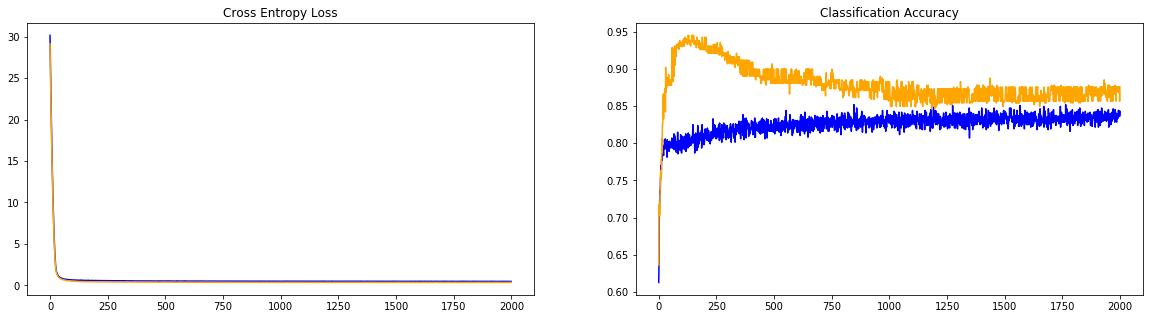

In [20]:
plt.figure(figsize=(20,5))
plt.subplot(121)
plt.title('Cross Entropy Loss')
plt.plot(history.history['loss'], color='blue', label='train')
plt.plot(history.history['val_loss'], color='orange', label='test')
# plot accuracy
plt.subplot(122)
plt.title('Classification Accuracy')
plt.plot(history.history['accuracy'], color='blue', label='train')
plt.plot(history.history['val_accuracy'], color='orange', label='test')

In [21]:
model.load_weights('./checkpoint.ckpt')
# evaluate
test_loss, test_acc = model.evaluate(testX,testY,verbose = 0)

print('test accuracy: {}, test loss: {}'.format(test_acc,test_loss))

test accuracy: 0.8755980730056763, test loss: 0.3518269774303482


In [22]:
# predictions
predictions = model.predict_classes(testX).reshape(len(testX))
# write csv file
submission =pd.DataFrame({'PassengerId':pId,'Survived':predictions})
submission.to_csv('Titanic Predictions.csv',index = False)